<img src="../img/htw-logo.png" width=150>


**I758 Wissens- und KI-basierte Systeme**

# Klassifikation mit kNN
Quelle: IBM Introduction to Machine Learning Specialization ([Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01))
 / Anpassungen CK
 

<font color="green"><b>KLAUSURTAUGLICH.</b></font>
Dieses Notebook gehört zu den fünf Notebooks, die Sie für die Klausur einreichen können. Bei vollständiger und korrekter Bearbeitung **erhalten Sie Punkte für die Abgabe, die zu Ihrer Klausur addiert werden.**

***

### Virtuelle Environments

**Hinweis:**:  In diesem Tutorial werden einige neue Bibliotheken wie z.B. die Visualisierungs-Bibliothek `seaborn` gebraucht. Mit ganz viel Glück sind diese Bibliotheken alle schon in Ihrem lokalen Environment installiert. Falls nicht, wird es Zeit, einmal die [Dokumentation von conda](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html) zu studieren.

Legen Sie mit conda eine neue virtuelle Umgebung mit (zum Beispiel mit dem Namen `07-class` an. Installieren Sie in dieser Umgebung die folgenden Pakete:
   
```
   pip install -qy pandas==1.3.3 numpy==1.21.2 ipywidgets==7.4.2 scipy==7.4.2 tqdm==4.62.3 matplotlib==3.5.0 seaborn==0.9.0
```

Stellen Sie diese Umgebung in Ihrem Jupyter Notebook als Python-Compiler ein und arbeiten Sie erst dann mit diesem Notebook weiter!

***

In dieser Übung lernen Sie das K-Nearest-Neighbor-Modell (KNN) kennen und üben es. KNN ist ein unkompliziertes, aber sehr effektives Modell, das sowohl für Klassifizierungs- als auch für Regressionsaufgaben verwendet werden kann. Wenn der Merkmalsraum nicht sehr groß ist, kann KNN ein gut interpretierbares Modell sein, da Sie anhand der nächsten Nachbarn erklären und verstehen können, wie eine Vorhersage getroffen wird.

Wir werden einen Tumorprobendatensatz verwenden, der Labortestergebnisse zu Tumorproben enthält. Ziel ist die Klassifizierung, ob ein Tumor bösartig (Krebs) oder gutartig ist. Daher handelt es sich um eine typische binäre Klassifizierungsaufgabe.

### Ziele
Nach Abschluss dieser Übung sollten Sie folgende Fähigkeiten und Kenntnisse haben:
* Trainining von KNN-Modellen mit verschiedenen Nachbar-Hyperparametern
* Bewertung von Modellen für Klassifizierungsaufgaben
* Modell-Optiomierung durch Finden eines optimalen Hyperparameters

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
# Evaluation metrics related methods
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Define a random seed to reproduce any random process
rs = 123

In [3]:
# Ignore any deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

### Laden und untersuchen Sie den Tumorprobendatensatz

Wir laden zunächst den Datensatz „tumor.csv“ als Pandas-Dataframe:

In [4]:
# Read dataset in csv format from online source
# dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/tumor.csv"
# exactly the same file, but local:
dataset_url = "./data/tumor.csv"
tumor_df = pd.read_csv(dataset_url)

<span style="color:#FF5F00"><b>AUFGABE 1:</b></span><br>
Wie sieht der Tabellenkopf aus?

In [5]:
tumor_df.head()

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


Was können wir über die Spalten erfahren?

In [6]:
tumor_df.columns

Index(['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc',
       'BlandChrom', 'NormNucl', 'Mit', 'Class'],
      dtype='object')

<span style="color:green"><b>Antwort zur AUFGABE 1:</b></span><br>

Auf dem ersten Blick gibt's nur numerische Werte (_erstmal ohne Null-Werten :D_), die viele medizinische Merkmale über den Tumor beschreiben. Da ich kein Artz oder Medizin-Studierender bin, kann ich nicht behaupten, was genau diese Merkmale bedeuten :(

Jede Beobachtung in diesem Datensatz enthält Labortestergebnisse zu einer Tumorprobe, beispielsweise Klumpen oder Formen. Basierend auf diesen Labortestergebnissen oder -merkmalen möchten wir ein Klassifizierungsmodell erstellen, um vorherzusagen, ob diese Tumorprobe bösartig (Krebs) oder gutartig ist. Die Zielvariable `y` wird in der Spalte `Class` angegeben.

Teilen wir die Daten in Input  `X` und Output `y` auf:


In [7]:
X = tumor_df.iloc[:, :-1]
y = tumor_df.iloc[:, -1:]

Wir schauen uns die Werte in `X` an:


In [8]:
X.describe()

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


Wie wir der obigen Zellenausgabe entnehmen können, sind alle Merkmale numerisch und liegen im Bereich zwischen 1 und 10. Dies ist sehr praktisch, da wir die Merkmalswerte nicht skalieren müssen, da sie bereits im gleichen Bereich liegen.

<span style="color:#FF5F00"><b>AUFGABE 2:</b></span><br>

Erstellen Sie einen Bar Chart, der Ihnen anzeigt, wie viele Tumore gutartig sind (y = 0) und wieviele krankhaft (y = 1). 
</div>

Tipp: Pandas bietet Ihnen dafür die `value_counts` - Funktion. Für einen Dataframe `df` können Sie außerdem mit `df.plot.bar()` einen Barchart plotten. Sie sollten auf ungefähr 65% gutartige Tumore kommen. 


<Axes: xlabel='Class'>

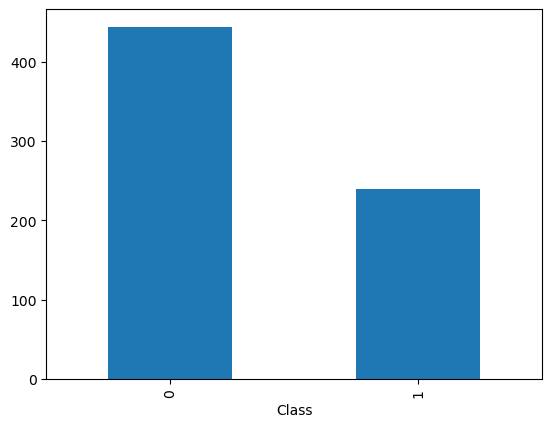

In [9]:
tumor_df["Class"].value_counts().plot(kind="bar")

### Trainings- und Testdatensätze verarbeiten und aufteilen

In [10]:
# Split 80% as training dataset
# and 20% as testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)

### Trainieren und bewerten Sie einen KNN-Klassifikator mit K=2

Das Training eines KNN-Klassifikators ist dem Training anderer Klassifikatoren in „sklearn“ sehr ähnlich. Wir müssen zunächst ein `KNeighborsClassifier`-Objekt definieren. Hier verwenden wir das Argument `n_neighbors=2`, um anzugeben, wie viele Nachbarn für die Vorhersage verwendet werden, und behalten andere Argumente als Standardwerte bei.

In [11]:
# Define a KNN classifier with `n_neighbors=2`
knn_model = KNeighborsClassifier(n_neighbors=2)

Dann können wir das Modell mit `X_train` und `y_train` trainieren und verwenden die `ravel()`-Methode, um den Dataframe `y_train` in einen Vektor umzuwandeln.

In [12]:
knn_model.fit(X_train, y_train.values.ravel())

,n_neighbors,2
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


Wir machen Vorhersagen auf  `X_test`:


In [13]:
preds = knn_model.predict(X_test)

Um die Modellqualität im Detail zu verstehen, zeichnen wir eine Confusion Matrix:

Text(0.5, 25.722222222222214, 'Ground Truth')

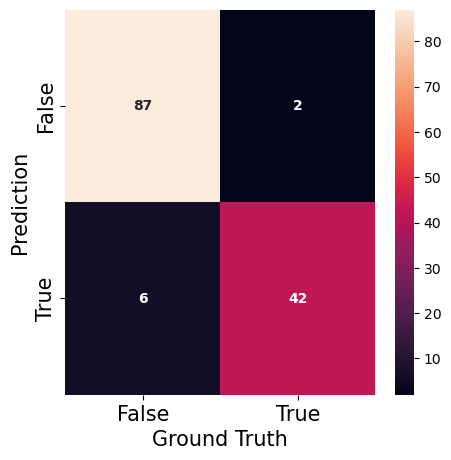

In [14]:
# This block had to be modified
# in order to display the matrix correctly

# Plot confusion matrix
sns.set_palette(sns.color_palette())
_, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(confusion_matrix(y_test, preds),
                 annot=True,
                 fmt='d',
                 annot_kws={
                     "size": 10,
                     "weight": "bold"
                 })
labels = ['False', 'True']
ax.set_xticklabels(labels, fontsize=15)
#*The rows were originally signed incorrectly
#*which made the confusion matrix even more confusing
# ax.set_yticklabels(labels[::-1], fontsize=15)
ax.set_yticklabels(labels, fontsize=15)

ax.set_ylabel('Prediction', fontsize=15)
ax.set_xlabel('Ground Truth', fontsize=15)

Um den KNN-Klassifikator auszuwerten, stellen wir eine vordefinierte Methode zur Verfügung, um die häufig verwendeten Bewertungsmetriken wie Genauigkeit, Rückruf, Präzision, f1score usw. basierend auf den wahren Klassen im `y_test` und den Modellvorhersagen zurückzugeben.

In [15]:
# This block had to be modified
# in order to retrieve the scores correctly

def evaluate_metrics (yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    #*For whatever reason the return values for recall and precision are swapped
    # precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, average='binary')
    recall, precision, f_beta, _ = precision_recall_fscore_support(yt, yp, average='binary')
    
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

In [16]:
metrics = evaluate_metrics(y_test, preds)
metrics

{'accuracy': 0.9416058394160584,
 'recall': 0.9545454545454546,
 'precision': 0.875,
 'f1score': 0.9130434782608695}

<span style="color:#FF5F00"><b>AUFGABE 3:</b></span><br>

Informieren Sie sich in der Dokumentation von SciKit Learn über die Definition dieser Metriken!  
Beschreiben Sie zusätzlich die Modellqualität anhand der Confusion Matrix.

<span style="color:green"><b>Antwort zur AUFGABE 3:</b></span><br>

Aus der Dokumentation zur [`precision_recall_fscore_support()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html) und [`accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#accuracy-score) kann man direkt die Bedeutungen von Ausgaben nachvollziehen:

- `accuracy` - Genauigkeit vom Modell als Anteil von richtigen Vorhersagen unter allen Vorhersagen.
- `precision` - Anteil von True-Positive Vorhersagen unter allen Positive Vorhersagen.
- `recall` - Anteil von True-Positive Vorhersagen unter True-Positive und False-Negative Vorhersagen.
- `F-Beta` - gewichtetes Mittelwert von `precision` und `recall` (_`recall` wird mehr gewichtet_).

Eine Deep-Dive Dokumentationsseite mit tieferen Theorie heiß [Metrics and scoring: quantifying the quality of predictions](https://scikit-learn.org/stable/modules/model_evaluation.html#metrics-and-scoring-quantifying-the-quality-of-predictions)

Die berechneten Evaluierungsmetriken zeigen insgesamt eine sehr hohe Genauigkeit von Vorhersagen (_ca. 90%_). Im Zusammenhang mit der Konfusion Matrix kann man folgendes schlussfolgern:

- Das Modell entscheidet seltener für False-Negative Cases als für False-Positive Cases.
- Der Anteil von True-Positive Vorhersagen unter allen positiven ist etwas geringer als der von True-Negative Vorhersagen unter allen negativen. 

Wir können sehen, dass der Tumorprobendatensatz eine hervorragende Klassifizierungsleistung aufweist. Dies bedeutet, dass das KNN-Modell Krebstumoren effektiv erkennen kann. Als nächstes sind Sie an der Reihe, eine andere Anzahl von Nachbarn auszuprobieren, um zu sehen, ob wir eine noch bessere Leistung erzielen könnten.

### Verbessern Sie das Modell

<span style="color:#FF5F00"><b>AUFGABE 4:</b></span><br>

Verbessern Sie das Modell, indem Sie einen weiteren kNN-Classifier trainieren, diesmal jedoch mit k=5.
</div>
Geben Sie eine Einschätzung zur Evaluierung des Modells ab.

Definieren Sie zunächst einen KNN-Klassifikator mit der Klasse KNeighborsClassifier:

In [17]:
knn_better_model = KNeighborsClassifier(n_neighbors=5)

Jetzt trainieren Sie das Modell mit  `X_train` und `y_train`:


In [18]:
knn_better_model.fit(X=X_train.values, y=y_train.values.ravel())

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


Machen Sie Vorhersagen auf  `X_test` und evaluieren Sie mit  `evaluate_metrics()` auf `y_test` und `preds`:


In [19]:
better_preds = knn_better_model.predict(X_test.values)
better_metrics = evaluate_metrics(y_test, better_preds)
print('Bessere Metriken:\n', better_metrics)

diff_metrics = {}
for m in better_metrics:
    diff_metrics[m] = round(better_metrics[m] - metrics[m], 2)
    
print('Differenz zwischen besseren und originalen Metriken:\n', diff_metrics)

Bessere Metriken:
 {'accuracy': 0.9781021897810219, 'recall': 0.9591836734693877, 'precision': 0.9791666666666666, 'f1score': 0.9690721649484536}
Differenz zwischen besseren und originalen Metriken:
 {'accuracy': 0.04, 'recall': 0.0, 'precision': 0.1, 'f1score': 0.06}


<span style="color:green"><b>Antwort zur AUFGABE 4:</b></span><br>

Alle Metriken haben sich um ein paar Prozente vergrößert. Das bedeutet eigentlich, das das Modell eine flüchtig höhere Genauigkeit als das erste hat.

### Finden Sie das beste Modell

<span style="color:#FF5F00"><b>AUFGABE 5:</b></span><br>

Verbessern Sie das Modell noch weiter, indem Sie den besten Wert für K finden.
</div>

Hier könnten wir K von 1 bis 50 ausprobieren und den aggregierten `f1score` für jedes k in einer Liste speichern.

In [20]:
# Try K from 1 to 50
max_k = 50
# Create an empty list to store f1score for each k
f1_scores = []

Dann trainieren wir 50 KNN-Klassifikatoren mit K im Bereich von 1 bis 50.
Vervollständigen Sie den folgenden Code:

In [21]:
# Train, test, repeat 
for k in range(1, max_k + 1):
    k_knn_model = KNeighborsClassifier(k)
    k_knn_model.fit(X_train.values, y_train.values.ravel())
    k_preds = k_knn_model.predict(X_test.values)

    # Evaluate the classifier with f1score and store result in list
    f1 = f1_score(k_preds, y_test)
    f1_scores.append((k, round(f1_score(y_test, k_preds), 4)))

# Convert the f1score list to a dataframe
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
f1_results.set_index('K')

,F1 Score
K,
1,0.9485
2,0.9130
3,0.9485
4,0.9583
5,0.9691
6,0.9583
7,0.9583
8,0.9474
9,0.9474


Dies ist eine lange Liste und unterscheidet sich von der Analyse. Lassen Sie uns die Liste also mithilfe eines Liniendiagramms visualisieren.

Text(0.5, 1.0, 'KNN F1 Score')

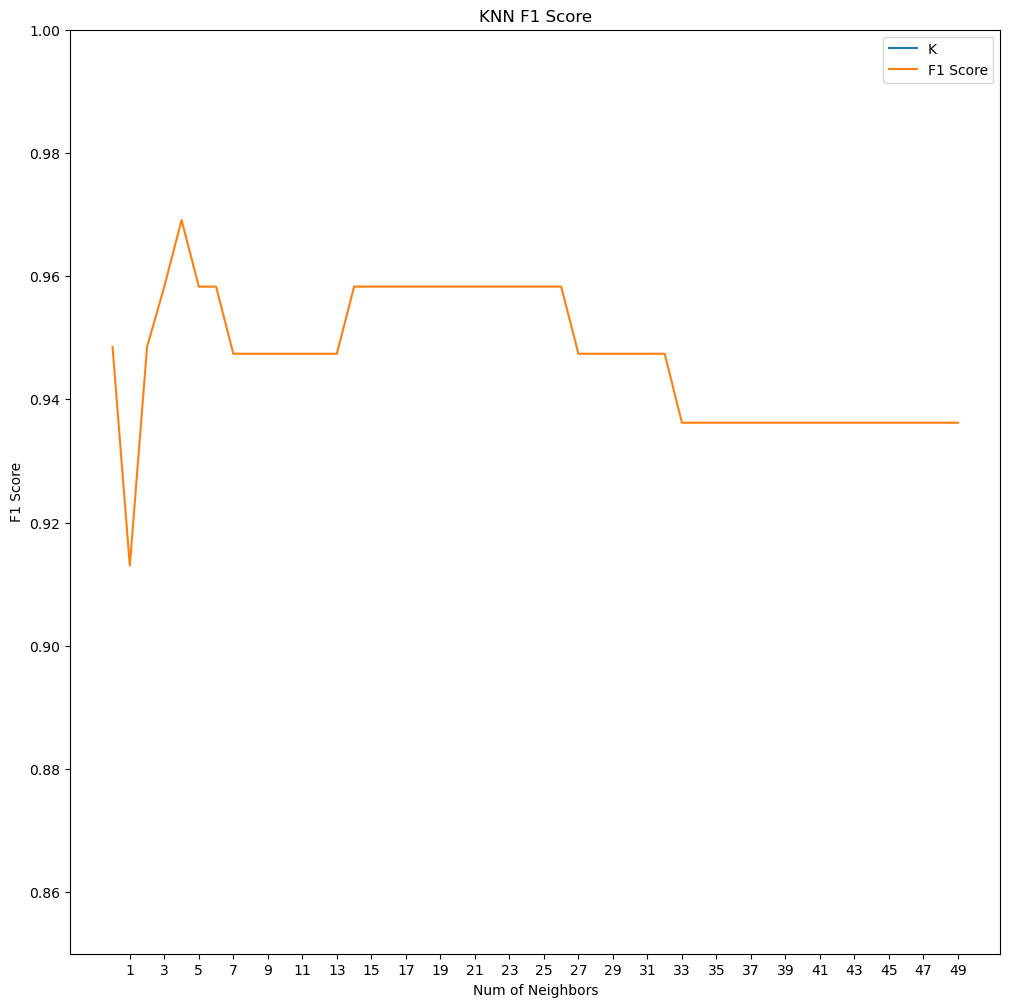

In [22]:
# Plot F1 results
ax = f1_results.plot(figsize=(12, 12))
ax.set(xlabel='Num of Neighbors', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2))
plt.ylim((0.85, 1))
plt.title('KNN F1 Score')

<span style="color:#FF5F00"><b>AUFGABE 6:</b></span><br>
Welches K ist das beste? Welchen F1-Score können Sie damit erreichen?
</div>

In [23]:
best_score = f1_results["F1 Score"].max()
best_k = f1_results.index[f1_results['F1 Score'] == best_score].values[0]

print('Der maximale Score:', best_score)
print('Das beste K:', best_k)

Der maximale Score: 0.9691
Das beste K: 4


<span style="color:green"><b>Antwort zur AUFGABE 6:</b></span><br>

Das beste K ist 4, weil bei ihm der höhste Score von 0.9691 erreicht wird.

<span style="color:#FF5F00"><b>AUFGABE 7:</b></span><br>
Welchen Effekt hat der Parameter K? Wovon ist der Parameter K abhängig?
</div>

<span style="color:green"><b>Antwort zur AUFGABE 7:</b></span><br>

In kNN Klassifizierung spielt der Parameter K die wichtigste Rolle. Er entscheidet, anhand wie vielen K Nachbarn die Klasse einer neuer Probe angelegt wird. Je größer K, desto geringer ist der eigener Einfluss eines Nachbars auf eine Probe. Da dieser Parameter ein Initialisierungsparameter für jeden kNN-Klassifikator ist, hängt er von keiner anderen Angabe ab.